# 1.0 Working on Signature Methods

In [1]:
from clustergrammer_widget import *
net = Network(clustergrammer_widget)
df = {}

import clustergrammer_groupby as cby
import gene_exp_10x

In [2]:
### signature distance calculation requirements
from sklearn.metrics import pairwise_distances
from scipy.stats import ttest_ind 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline 

### Load Default Dataset

In [3]:
net.load_file('../data/rc_two_cats.txt')
df['ini'] = net.export_df()
df['ini'].shape

### Drop Gender Category
cols = df['ini'].columns.tolist()
new_cols = []
for inst_col in cols:
    inst_col = list(inst_col)
    new_col = tuple(inst_col[:2])
    new_cols.append(new_col)

df['ini'].columns = new_cols

### Set category colors

In [4]:
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: one', inst_color='red')
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: two', inst_color='blue')
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: three', inst_color='yellow')
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: four', inst_color='black')
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: five', inst_color='purple')

In [5]:
net.load_df(df['ini'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


### Calculate Signatures of Categories

In [6]:
df['ini_mi'] = cby.row_tuple_to_multiindex(df['ini'].transpose())

### Collect Top diff genes using T-test

In [7]:
def generate_signatures(df, category_level):

    num_top_genes = False
    pval_cutoff = 0.05

    cell_types = sorted(list(set(df.index.get_level_values(category_level).tolist())))

    inst_level = 'Category'

    keep_genes = []
    keep_genes_dict = {}

    for inst_ct in cell_types:

        inst_ct_mat = df.xs(key=inst_ct, level=inst_level)
        inst_other_mat = df.drop(inst_ct, level=inst_level)

        inst_stats, inst_pvals = ttest_ind(inst_ct_mat, inst_other_mat, axis=0)

        ser_pval = pd.Series(data=inst_pvals, index=df.columns.tolist()).sort_values()

        if num_top_genes == False:
            ser_pval_keep = ser_pval[ser_pval < pval_cutoff]
        else:
            ser_pval_keep = ser_pval[:num_top_genes]

        inst_keep = ser_pval_keep.index.tolist()
        keep_genes.extend(inst_keep)
        keep_genes_dict[inst_ct] = inst_keep

    keep_genes = sorted(list(set(keep_genes)))
    
    df_gbm = df.groupby(level=inst_level).mean().transpose()
    cols = df_gbm.columns.tolist()
    new_cols = []
    for inst_col in cols:
        new_col = (inst_col, inst_level + ': ' + inst_col)
        new_cols.append(new_col)
    df_gbm.columns = new_cols    
    
    df_sig = df_gbm.ix[keep_genes]    
    
    return df_sig, keep_genes, keep_genes_dict

In [8]:
df['cat_sig'], keep_genes, keep_genes_dict = generate_signatures(df['ini_mi'], 'Category')

# Category Signature

In [9]:
net.load_df(df['cat_sig'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


### Visualize Informative Dimensions in Original Data
Generate a matrix with only category-informative dimensions/genes.

In [10]:
net.load_df(df['ini'].ix[keep_genes])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


# Predict Category Based on Signature

In [11]:
def predict_cat_from_sig(df_data_ini, df_sig, dist_type='cosine'):
    print('df_data_ini: ', df_data_ini.shape)

    keep_rows = df_sig.index.tolist()
    df_data = deepcopy(df_data_ini.ix[keep_rows])
    print('df_data: ', df_data.shape)

    # calculate sim_mat of df_data and df_sig
    cell_types = df_sig.columns.tolist()
    barcodes = df_data.columns.tolist()
    sim_mat = 1 - pairwise_distances(df_sig.transpose(), df_data.transpose(), metric=dist_type)
    df_sim = pd.DataFrame(data=sim_mat, index=cell_types, columns=barcodes).transpose()
    print(df_sim.shape)

    ser_list = []
    top_list = []
    rows = df_sim.index.tolist()
    for inst_row in rows:

        # make ser_data_sim
        inst_ser = df_sim.loc[[inst_row]]
        inst_data = inst_ser.get_values()[0]
        inst_cols = inst_ser.columns.tolist()
        ser_data_sim = pd.Series(data=inst_data, index=inst_cols, name=inst_row).sort_values(ascending=False)

        # define top matching cell type
        top_ct_1 = ser_data_sim.index.tolist()[0]        

        # use cell type signature
        found_ct = top_ct_1

        # make binary matrix of ct_max
        inst_zeros = np.zeros((len(inst_cols)))
        max_ser = pd.Series(data=inst_zeros, index=inst_cols, name=inst_row)
        max_ser[found_ct] = 1
        top_list.append(found_ct)
        ser_list.append(max_ser)

    # make matrix of top cell type identified 
    df_sim_top = pd.concat(ser_list, axis=1).transpose()

    y_info = {}
    y_info['true'] = []
    y_info['pred'] = []

    # add cell type category to input data
    df_cat = deepcopy(df_data)
    cols = df_cat.columns.tolist()
    new_cols = []
    for i in range(len(cols)):
        inst_col = list(cols[i])
        inst_col.append('Predict Category: ' + top_list[i][0])
        inst_tuple = tuple(inst_col)
        new_cols.append(inst_tuple)

        # store true and predicted lists 
        y_info['true'].append(inst_col[1].split(': ')[1])
        y_info['pred'].append(top_list[i][0])

    df_cat.columns = new_cols
    
    return df_cat, df_sim.transpose(), df_sim_top.transpose(), y_info


### Run prediction function

In [12]:
df['pred_cat'], df['sig_sim'], df['sig_max'], y_info = predict_cat_from_sig(df['ini'], df['cat_sig'])

df_data_ini:  (38, 29)
df_data:  (19, 29)
(29, 5)


In [13]:
net.load_df(df['pred_cat'])
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: one', inst_color='red')
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: two', inst_color='blue')
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: three', inst_color='yellow')
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: four', inst_color='black')
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: five', inst_color='purple')

In [14]:
net.load_df(df['pred_cat'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [15]:
net.load_df(df['sig_sim'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [16]:
net.load_df(df['sig_max'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


### F1 Scores

In [17]:
print(f1_score(y_info['true'], y_info['pred'], average='macro'))
print(f1_score(y_info['true'], y_info['pred'], average='micro'))
print(f1_score(y_info['true'], y_info['pred'], average='weighted'))

0.825734265734
0.827586206897
0.820352061731


In [18]:
def count_cats(y_info):

    a = deepcopy(y_info['true'])
    true_count = dict((i, a.count(i)) for i in set(a))

    a = deepcopy(y_info['pred'])
    pred_count = dict((i, a.count(i)) for i in set(a))
    
    fraction_correct = f1_score(y_info['true'], y_info['pred'], average='micro')

    return true_count, pred_count, fraction_correct

In [19]:
true_count, pred_count, fraction_correct = count_cats(y_info)

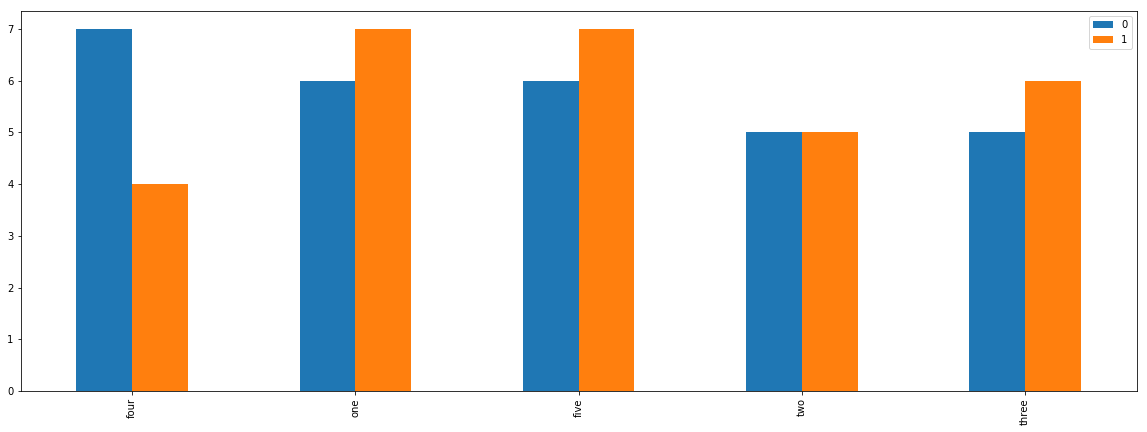

In [20]:
ser_orig_pop = pd.Series(true_count).sort_values(ascending=False)
ser_pred_pop = pd.Series(pred_count).sort_values(ascending=False)
df['compare_pop'] = pd.concat([ser_orig_pop, ser_pred_pop], axis=1)
df['compare_pop'] = df['compare_pop'].loc[ser_orig_pop.index.tolist()]
df['compare_pop'].plot(kind='bar', figsize=(20,7))

### Calculate confusion matrix

In [21]:
sorted_cats = sorted(list(set(y_info['true'])))
conf_mat = confusion_matrix(y_info['true'], y_info['pred'], sorted_cats)
df['conf'] = pd.DataFrame(conf_mat, index=sorted_cats, columns=sorted_cats)

In [22]:
net.load_df(df['conf'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [23]:
total_correct = np.trace(df['conf'])
total_pred = df['conf'].sum().sum()

In [24]:
fraction_correct = total_correct/float(total_pred)
fraction_correct

0.82758620689655171

### Calculate the fraction of correct predictions for each category type

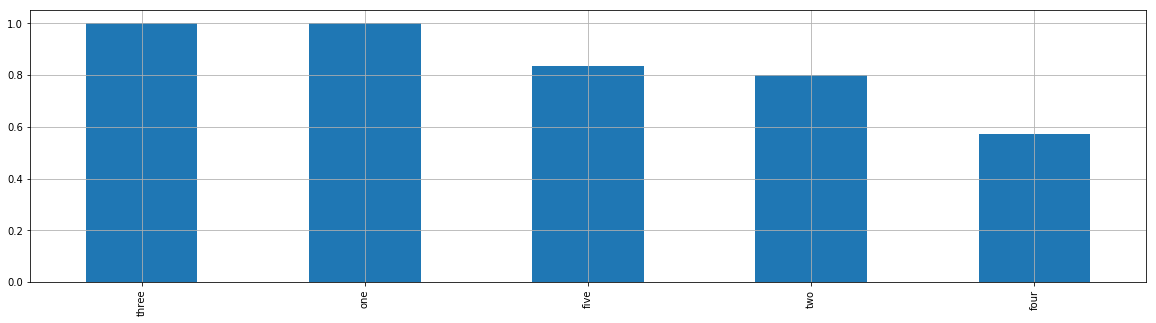

In [25]:
correct_list = []
cat_counts = df['conf'].sum(axis=1)
all_cols = df['conf'].columns.tolist()
for inst_cat in all_cols:
    inst_correct = df['conf'][inst_cat].loc[inst_cat] / cat_counts[inst_cat]
    correct_list.append(inst_correct)
    
ser_correct = pd.Series(data=correct_list, index=all_cols)
ser_correct.sort_values(ascending=False).plot(kind='bar', figsize=(20,5), grid=True)

### Set up Shuffling 